In [1]:
pip install pennylane --upgrade

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, QNSPSAOptimizer, GradientDescentOptimizer
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [3]:
np.random.seed(422)


def make_dataset(samples, center=[0.0, 0.0], ellipse_params=[0.4, 0.9]):
    X, Y = [], []

    for i in range(samples):
        x, y = 2 * (np.random.rand(2)) - 1, 0
        if  (x[0]/(ellipse_params[0]))**2 + (x[1]/(ellipse_params[1]))**2 <= 1:
            y = 1
        X.append(x)
        Y.append(y)
    return np.array(X, requires_grad=False), np.array(Y, requires_grad=False)




In [4]:
def density_matrix(state):
    return state * np.conj(state).T

In [5]:
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y):
    """
    4 layers
    params = [
        [phi1, theta1, omega1], # first layer
        [phi2, theta2, omega2], # 2nd layer
        [phi3, theta3, omega3],
        [phi4, theta4, omega4],
        [phi5, theta5, omega5],
    ]
    x = [x1, x2, 0]
    y = [[1, 0],   or   [[0, 0],
         [0, 0]]         [0, 1]]
    """
    for i, p in enumerate(params):
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)

    return qml.expval(qml.Hermitian(y, wires=[0]))


@qml.qnode(dev)
def qcircuit_without_reuploading(params, x, y):
    qml.Rot(*x, wires=0)
    for i, p in enumerate(params):
        qml.Rot(*p, wires=0)

    return qml.expval(qml.Hermitian(y, wires=[0]))


params = np.random.uniform(size=(4, 3), requires_grad=True)

x = np.array([0.12, 0.35, 0])
y = np.array([[0, 0], [0, 1]])

print(qml.draw(qcircuit)(params, x, y))
print("-"*150)
print(qml.draw(qcircuit_without_reuploading)(params, x, y))

0: ──Rot(0.12,0.35,0.00)──Rot(0.25,0.37,0.18)──Rot(0.12,0.35,0.00)──Rot(0.73,0.96,0.56)

───Rot(0.12,0.35,0.00)──Rot(0.88,0.73,0.78)──Rot(0.12,0.35,0.00)──Rot(0.66,0.60,0.05)─┤  <𝓗(M0)>

M0 = 
[[0 0]
 [0 1]]
------------------------------------------------------------------------------------------------------------------------------------------------------
0: ──Rot(0.12,0.35,0.00)──Rot(0.25,0.37,0.18)──Rot(0.73,0.96,0.56)──Rot(0.88,0.73,0.78)

───Rot(0.66,0.60,0.05)─┤  <𝓗(M0)>

M0 = 
[[0 0]
 [0 1]]


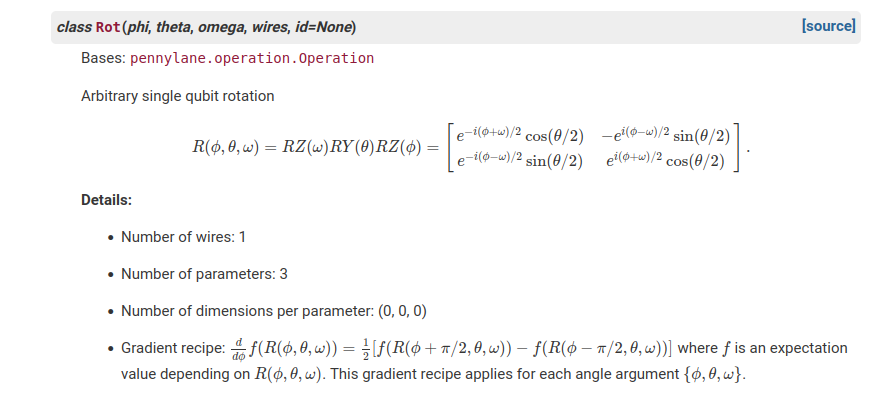

In [6]:
def cost(params, x, y, state_labels=None, ansatz=qcircuit):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        # forward pass
        f = ansatz(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)


def cost_with_classical_layer(params, x, y, state_labels=None, ansatz=qcircuit):
    """
    params = [
        [a1, a2, a3],
        [a4, a5, a6],
        [a7, a8, a9], # A @ (x1, x2, 0)
        []*5 # quantum trainable angels
    ]
    """
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]

    for i in range(len(x)):
        # forward pass
        f = ansatz(params[3:], params[:3] @ x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)


def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)


def get_batch(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [7]:
def test(ansatz, params, x, y, state_labels=None):
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: ansatz(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)

    return np.array(predicted)


def test_with_classical_layer(ansatz, params, x, y, state_labels=None):
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: ansatz(params[3:], params[:3] @ x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)

    return np.array(predicted)

In [8]:
def train(epochs: int, batch_size: int,
          X_train: np.array, Y_train: np.array,
          X_test: np.array, Y_test: np.array,
          lr, ansatz, cost_func, test, params):

    opt = AdamOptimizer(lr, beta1=0.9, beta2=0.999)
    train_acc_history, test_acc_history = [], []

    for it in range(epochs):
        for x, y in get_batch(X_train, Y_train, batch_size=batch_size):
            params, _, _, _ = opt.step(cost_func, params, x, y, state_labels, ansatz=qcircuit)

        predicted_train = test(qcircuit, params, X_train, Y_train, state_labels)
        acc_train = accuracy(Y_train, predicted_train)

        loss = cost_func(params, X_train, Y_train, state_labels, ansatz=qcircuit)

        predicted_test = test(qcircuit, params, X_test, Y_test, state_labels)
        acc_test = accuracy(Y_test, predicted_test)

        print(f"epoch: {it} | loss: {loss} | train acc: {acc_train} | test acc: {acc_test}")

        train_acc_history.append(acc_train)
        test_acc_history.append(acc_test)

    return (train_acc_history, test_acc_history)


def plot_history(first, second):
    x = range(0, len(first))
    xarr = np.array([[x],[x]])
    yarr = np.array([[first],[second]])

    for i in range(2):
        plt.plot(xarr[i,0], yarr[i,0])
    plt.show()

epoch: 0 | loss: 0.12519921402175557 | train acc: 0.855 | test acc: 0.845
epoch: 1 | loss: 0.09722937411264612 | train acc: 0.909 | test acc: 0.895
epoch: 2 | loss: 0.08680472718034032 | train acc: 0.922 | test acc: 0.915
epoch: 3 | loss: 0.0825949093030239 | train acc: 0.91 | test acc: 0.9
epoch: 4 | loss: 0.08321319004776247 | train acc: 0.892 | test acc: 0.895
epoch: 5 | loss: 0.08212018279300536 | train acc: 0.896 | test acc: 0.89
epoch: 6 | loss: 0.08110971303530498 | train acc: 0.898 | test acc: 0.895
epoch: 7 | loss: 0.08067732695151185 | train acc: 0.9 | test acc: 0.89
epoch: 8 | loss: 0.08047810195153596 | train acc: 0.903 | test acc: 0.89
epoch: 9 | loss: 0.0802612387329726 | train acc: 0.903 | test acc: 0.885


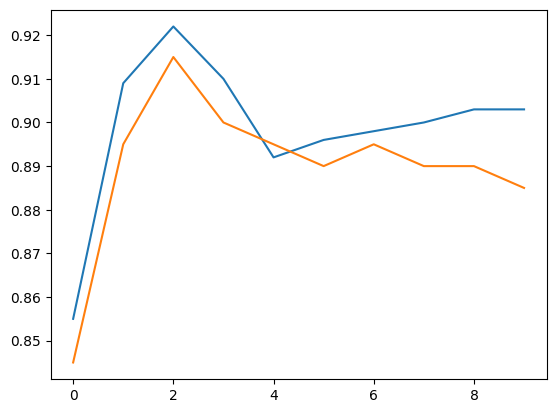

epoch: 0 | loss: 0.10150084215588523 | train acc: 0.871 | test acc: 0.88
epoch: 1 | loss: 0.0831013672487901 | train acc: 0.895 | test acc: 0.905
epoch: 2 | loss: 0.08110680531496141 | train acc: 0.897 | test acc: 0.91
epoch: 3 | loss: 0.07588665004719242 | train acc: 0.897 | test acc: 0.905
epoch: 4 | loss: 0.06793857592967839 | train acc: 0.928 | test acc: 0.915
epoch: 5 | loss: 0.06493972041087907 | train acc: 0.937 | test acc: 0.925
epoch: 6 | loss: 0.06466508544601918 | train acc: 0.937 | test acc: 0.935
epoch: 7 | loss: 0.06435817873953004 | train acc: 0.939 | test acc: 0.94
epoch: 8 | loss: 0.06428123394053252 | train acc: 0.939 | test acc: 0.94
epoch: 9 | loss: 0.06418561929826755 | train acc: 0.941 | test acc: 0.94


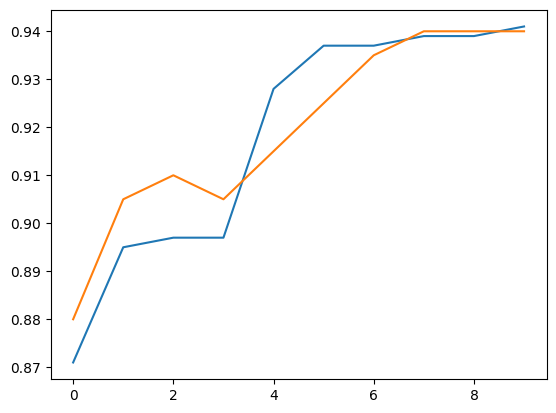

In [9]:
num_training = 1000
num_test = 200

Xdata, y_train = make_dataset(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = make_dataset(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))

learning_rate = 0.1
epochs = 10
batch_size = 32


# train without re-uploading
params_copy1 = np.random.uniform(size=(5, 3), requires_grad=True)
train_hist2, test_hist2 = train(
    epochs, batch_size, X_train, y_train, X_test, y_test, learning_rate,
    qcircuit_without_reuploading, cost, test, params_copy1
)

plot_history(train_hist2, test_hist2)


# train with re-uploading
params_copy2 = np.random.uniform(size=(5, 3), requires_grad=True)
train_hist1, test_hist1 = train(
    epochs, batch_size, X_train, y_train, X_test, y_test, learning_rate,
    qcircuit, cost, test, params_copy2
)

plot_history(train_hist1, test_hist1)

Experiments with single classical layer and quantum circuit

$params \in M_{9, 3}(\mathbf{R})$ \\
$A \in M_{3, 3}(\mathbf{R})$ \\
A = params[:3] , trainable

A @ (x1, x2, 0), params[3:8] -> quantum circuit


epoch: 0 | loss: 0.08667745863592763 | train acc: 0.904 | test acc: 0.895
epoch: 1 | loss: 0.06264042226217045 | train acc: 0.932 | test acc: 0.93
epoch: 2 | loss: 0.06055542479208272 | train acc: 0.932 | test acc: 0.925
epoch: 3 | loss: 0.06249770228219782 | train acc: 0.926 | test acc: 0.91
epoch: 4 | loss: 0.06326391370181385 | train acc: 0.921 | test acc: 0.905
epoch: 5 | loss: 0.06246057859803318 | train acc: 0.923 | test acc: 0.91
epoch: 6 | loss: 0.06121179049043763 | train acc: 0.926 | test acc: 0.91
epoch: 7 | loss: 0.060198489470635164 | train acc: 0.924 | test acc: 0.905
epoch: 8 | loss: 0.05918590533610782 | train acc: 0.925 | test acc: 0.91
epoch: 9 | loss: 0.05787339118527974 | train acc: 0.925 | test acc: 0.915


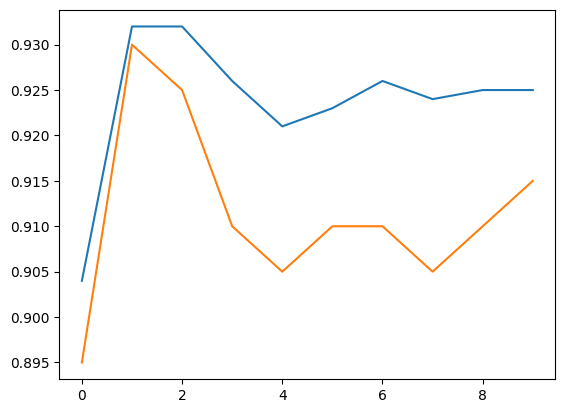

epoch: 0 | loss: 0.08291316892150254 | train acc: 0.885 | test acc: 0.915
epoch: 1 | loss: 0.07150970624840443 | train acc: 0.909 | test acc: 0.885
epoch: 2 | loss: 0.062213993635300516 | train acc: 0.95 | test acc: 0.94
epoch: 3 | loss: 0.06133574525165945 | train acc: 0.947 | test acc: 0.935
epoch: 4 | loss: 0.061626878355461226 | train acc: 0.944 | test acc: 0.935
epoch: 5 | loss: 0.06157922816718214 | train acc: 0.941 | test acc: 0.93
epoch: 6 | loss: 0.06181973090683041 | train acc: 0.939 | test acc: 0.925
epoch: 7 | loss: 0.06198050308037479 | train acc: 0.94 | test acc: 0.915
epoch: 8 | loss: 0.06194897791322558 | train acc: 0.939 | test acc: 0.92
epoch: 9 | loss: 0.06174050325939604 | train acc: 0.939 | test acc: 0.925


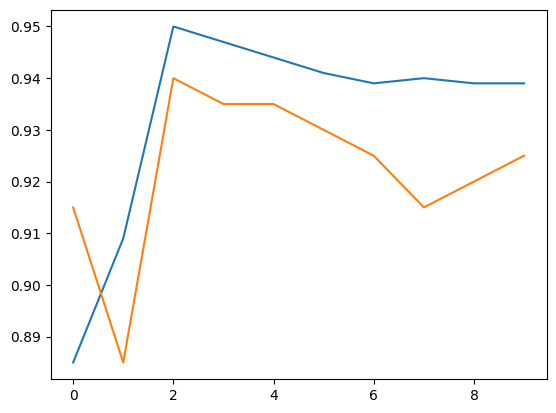

In [10]:
# train without re-uploading and classical layer
params_copy3 = np.random.uniform(size=(8, 3), requires_grad=True)
train_hist3, test_hist3 = train(
    epochs, batch_size, X_train, y_train, X_test, y_test, learning_rate,
    qcircuit, cost_with_classical_layer, test_with_classical_layer, params_copy3
)

plot_history(train_hist3, test_hist3)


# train with re-uploading and classical layer
params_copy4 = np.random.uniform(size=(8, 3), requires_grad=True)
train_hist4, test_hist4 = train(
    epochs, batch_size, X_train, y_train, X_test, y_test, learning_rate,
    qcircuit_without_reuploading, cost_with_classical_layer,
    test_with_classical_layer, params_copy4
)

plot_history(train_hist4, test_hist4)